In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from help_functions import create_model

In [4]:
IMAGE_DIMENSION = 64

In [5]:
# checkpoint_dir = 'checkpoints/naive_26_labels_weights_20220602/' # shit
# checkpoint_dir = 'checkpoints/naive_14_labels_weights_20220603/' # shit
# checkpoint_dir = 'checkpoints/naive_26_labels_weights_20220603_tiziano/' # shit
# checkpoint_dir = 'checkpoints/ores_10_labels_no_weights_20220604/'
# checkpoint_dir = 'checkpoints/ores_10_labels_weights_20220604/'
checkpoint_dir = 'checkpoints/naive_10_labels_weights_20220605/'


In [6]:
training_metrics = pd.read_csv(checkpoint_dir + 'history.csv')
print(training_metrics.shape)
training_metrics

(14, 7)


,epoch,accuracy,categorical_accuracy,loss,val_accuracy,val_categorical_accuracy,val_loss
0,0,0.237199,0.237199,0.085938,0.258175,0.258175,0.289264
1,1,0.243228,0.243228,0.084534,0.255684,0.255684,0.290114
2,2,0.245210,0.245210,0.084194,0.242667,0.242667,0.292594
3,3,0.245477,0.245477,0.084076,0.253614,0.253614,0.288835
4,4,0.246910,0.246910,0.084152,0.259544,0.259544,0.289386
5,5,0.247296,0.247296,0.083822,0.251368,0.251368,0.288016
6,6,0.247084,0.247084,0.083962,0.244211,0.244211,0.293798
7,7,0.247799,0.247799,0.084461,0.260070,0.260070,0.287419
8,8,0.250995,0.250995,0.083884,0.262982,0.262982,0.289626
9,9,0.248403,0.248403,0.083598,0.254070,0.254070,0.289561


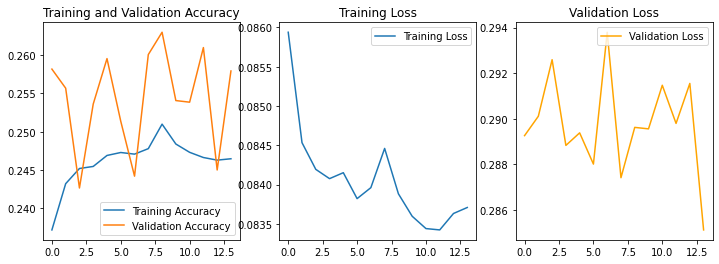

In [7]:
# Plot training metrics: loss & accuracy

epochs = training_metrics.shape[0]

acc = training_metrics.accuracy.values
loss = training_metrics.loss.values

val_acc = training_metrics.val_accuracy.values
val_loss = training_metrics.val_loss.values

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(range(epochs), loss, label='Training Loss')
# plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1, 3, 3)
# plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

In [9]:
# train_df = pd.read_json('data/training_set_10_labels.json.bz2', compression='bz2')
# test_df = pd.read_json('data/test_set_10_labels.json.bz2', compression='bz2')

data_dir = 'data/splitted_dfs_600k_20220603/'
test_df = pd.read_json(data_dir + 'test_df.json.bz2', compression='bz2')


# test_generator = ImageDataGenerator() 
# print('\n----------- Test images -----------')          
# test = test_generator.flow_from_dataframe(dataframe=train_df,
#                                           directory='/scratch/WIT_Dataset/images',
#                                           x_col='url', 
#                                           y_col='labels', 
#                                           batch_size=32,
#                                           class_mode='categorical',
#                                           validate_filenames=True,
#                                           target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))
datagen = ImageDataGenerator() 
test = datagen.flow_from_dataframe(
        dataframe=test_df, 
        directory='/scratch/WIT_Dataset/images',
        # subset='validation',
        # classes=topics,
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
        shuffle=False
        )

N_LABELS = len(test.class_indices)

Found 30000 validated image filenames belonging to 14 classes.


In [10]:
# Create model and load model weights
model = create_model(model_name='EfficientNetB0', n_labels=N_LABELS, image_dimension=IMAGE_DIMENSION)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
model.load_weights(latest)

# Evaluate model
# model.evaluate(test, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               655488    
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1806      
Total params: 4,706,865
Trainable params: 657,294
Non-trainable params: 4,049,571
_________________________________________________________________
None
checkpoints/naive_10_labels_weights_20220605/cp-0014.ckpt


In [11]:
from sklearn.metrics import roc_auc_score, classification_report, average_precision_score

predictions = model.predict(test, verbose=1)
threshold = 0.5
y_pred = 1 * (predictions > threshold)
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1


938/938 [==============================] - 55s 59ms/step


ROC AUC: 0.5484
               precision    recall  f1-score  support index
Culture         0.732143  0.004520  0.008985   9070.0     0
Entertainment   0.207547  0.026036  0.046267    845.0     1
Events          0.170455  0.036496  0.060120    411.0     2
History         0.492424  0.009233  0.018126   7040.0     3
Nature          0.457919  0.263892  0.334827   5237.0     4
Objects         0.400000  0.004124  0.008163    970.0     5
People          0.282392  0.042692  0.074171   1991.0     6
Places          0.681117  0.318358  0.433906  13177.0     7
Plants          0.428261  0.505128  0.463529    390.0     8
Politics        0.342995  0.063792  0.107576   1113.0     9
Science         0.000000  0.000000  0.000000    606.0    10
Society         0.600000  0.000452  0.000903   6639.0    11
Sports          0.437294  0.260059  0.326154   1019.0    12
Technology      0.203947  0.049051  0.079082    632.0    13
micro avg       0.564198  0.129752  0.210983  49140.0  None
macro avg       0.388321

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Culture 41/9070 == 0.005
Entertainment 22/845 == 0.026
Events 15/411 == 0.036
History 65/7040 == 0.009
Nature 1382/5237 == 0.264
Objects 4/970 == 0.004
People 85/1991 == 0.043
Places 4195/13177 == 0.318
Plants 197/390 == 0.505
Politics 71/1113 == 0.064
Science 0/606 == 0.0
Society 3/6639 == 0.0
Sports 265/1019 == 0.26
Technology 31/632 == 0.049


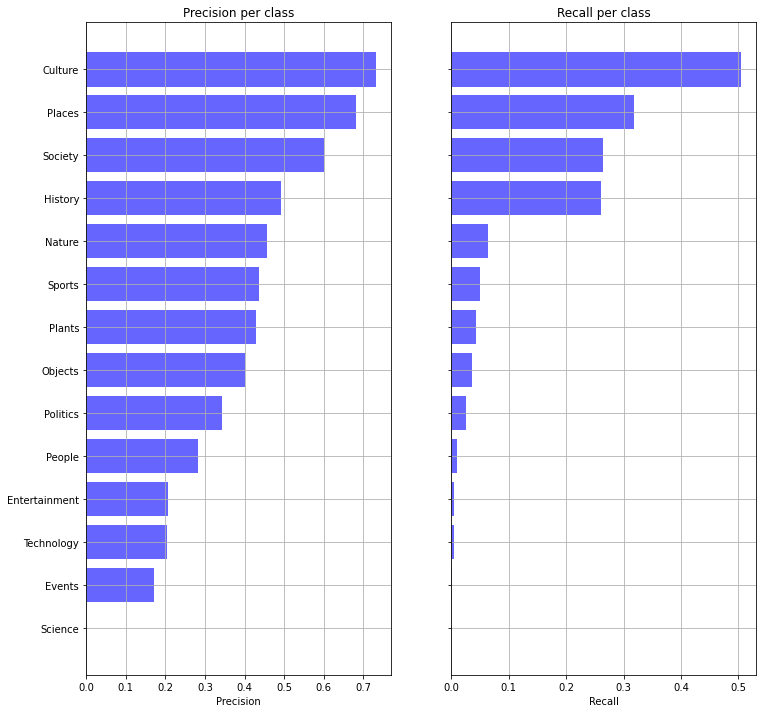

In [12]:
# N_CLASSES = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_LABELS), [None, None, None, None]))
print(metrics_df)

fig, axs = plt.subplots(1, 2, figsize=(12,12))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:N_LABELS])
sorted_precisions_per_class = metrics_df.precision[0:N_LABELS][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:N_LABELS])
sorted_recalls_per_class = metrics_df.recall[0:N_LABELS][sorted_indices_recall]

print('\n\n ----------- PER-CLASS ACCURACY ----------- \n ')
# Per-class accuracy
from collections import Counter
total = Counter()
correct = Counter()
for i in range(len(test.classes)):
    true_y = test.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(predictions[i]>=0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

name_id_map = test.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k
            
for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], round(correct[k]/total[k], 3)))
                
axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(N_LABELS))
axs[0].set_yticklabels(np.array(list(test.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)

axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(N_LABELS))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)

#### ROC curve for each class

On micro and macro averaging: Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

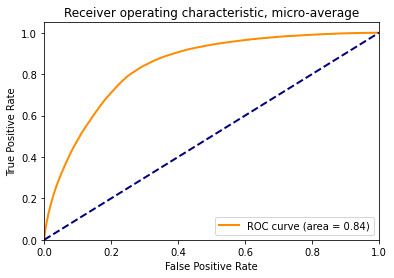

In [71]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_LABELS):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(
    fpr['micro'],
    tpr['micro'],
    color="darkorange",
    lw=lw,
    label=f"ROC curve (area = {roc_auc['micro']:.2f})"
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic, micro-average")
plt.legend(loc="lower right")
plt.show()

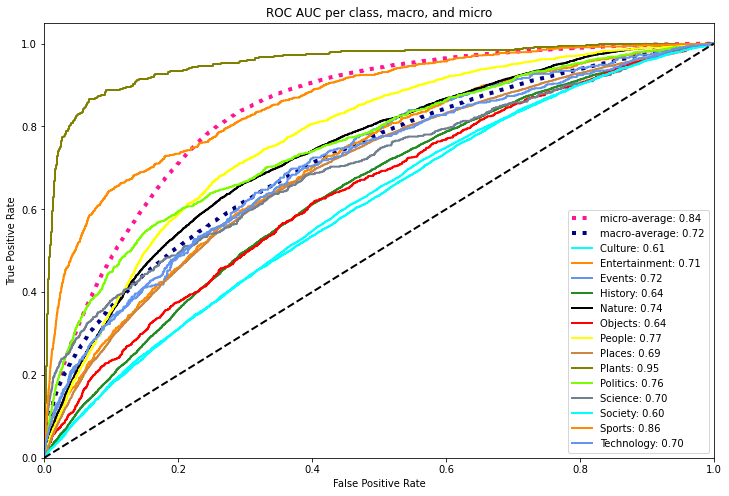

In [66]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_LABELS)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_LABELS):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= N_LABELS

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.figure(figsize=(12, 8))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average: { roc_auc['micro'] :0.2f}",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average: { roc_auc['macro'] :0.2f}",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "black", "red", "yellow", "peru", "olive", "lawngreen", "slategray"])
for i, color in zip(range(N_LABELS), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label=f"{list(name_id_map.keys())[i]}: {roc_auc[i]:0.2f}"
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC per class, macro, and micro")
plt.legend(loc="lower right")
plt.show()